In [1]:
#https://blog.csdn.net/weixin_41579863/article/details/106420535

%load_ext autoreload
%autoreload 2
from davidyu_cfg import *
from finquant.portfolio import build_portfolio
from functions.common.dfcf_fuquan_data import *

2021-03-04 10:50:58,002 - davidyu_cfg.py[line:41] - INFO: load log module
2021-03-04 10:50:58,023 - davidyu_cfg.py[line:43] - INFO: load data_dir module
2021-03-04 10:50:58,027 - davidyu_cfg.py[line:45] - INFO: load make_dir module


In [12]:
from easydl import clear_output

def find_same_date(stock_list,start_date,end_date):
    k=0
  
    for s1 in stock_list:
        if k==0:
            df1 = dfcf_stock_data(s1,start_date,end_date)
            df1 = df1[["dt","close"]].drop_duplicates()
            a = df1["dt"].tolist()
            k+=1
        else:
            df1 = dfcf_stock_data(s1,start_date,end_date)
            df1 = df1[["dt","close"]].drop_duplicates()
            b = df1["dt"].tolist()
            a = list(set(a).intersection(set(b))) 
    return a


def same_date_returns(stock_list,start_date,end_date,same_date):
    df_return_list = []
    stock_index_list = []
    for s1 in stock_list:
        df1 = dfcf_stock_data(s1,start_date,end_date)
        df1 = df1[["dt","close"]].drop_duplicates()
        df_test = df1["close"]
        dates = df1.dt.values
        df_test.index = dates
        df_test.index.name = 'Date'
        # calculate daily returns
        daily_returns = df_test.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
        # find returns in the same date
        df_return_update = daily_returns[daily_returns.index.isin(same_date)]
        df_return_list.append(df_return_update.values.tolist())
        stock_index_list.append(s1)
        date_index = df_return_update.index.tolist()
    df_out = pd.DataFrame(df_return_list).T
#     df_out.shape
    df_out.index=date_index
#     print(df_out.head(30))
    df_out.columns = stock_index_list
    return df_out 

def plot_stocks(daily_returns, freq=252):
    import matplotlib.pylab as plt

    """Plots the Expected annual Returns over annual Volatility of
    the stocks of the portfolio.

    :Input:
     :freq: ``int`` (default: ``252``), number of trading days, default
         value corresponds to trading days in a year.
    """
    # annual mean returns of all stocks
    stock_returns = daily_returns.mean()*freq
    stock_volatility = daily_returns.std() * np.sqrt(freq)
    # adding stocks of the portfolio to the plot
    # plot stocks individually:
#     fig = plt.figure(figsize=(20,10))
    plt.scatter(stock_volatility, stock_returns, marker="o", s=100, label="Stocks")
    # adding text to stocks in plot:
    for i, txt in enumerate(stock_returns.index):
        plt.annotate(
            txt,
            (stock_volatility[i], stock_returns[i]),
            xytext=(10, 0),
            textcoords="offset points",
            label=i,
        )
        plt.legend()
        
def plot_stock_simulation(df_returns,if_plot=0):
    wt = np.ones(df_returns.shape[1])*(1/df_returns.shape[1])
    mc = MonteCarloOpt(df_returns,num_trials=5000,risk_free_rate=0.005,
            freq=252,
            initial_weights=wt)
#     print(wt)
    opt_w, opt_res = mc.optimisation()
    if if_plot==1:
        ef = EfficientFrontier(
                df_returns.mean()*1,
                df_returns.cov(),
                risk_free_rate=0.005,
                freq=252,
            )
        mc.plot_results()
        ef.plot_efrontier()
        ef.plot_optimal_portfolios()
        # plotting individual stocks
        plot_stocks(df_returns)
    return opt_w,opt_res
# len(a)
#r = list(set(a).intersection(b,c)) 

In [26]:
stock_list = "002803,002810,000157,603697,600761,002595,601100,300371,603856,603416"
#stock_list = "601328"
#stock_list = "002157,002041,600048"
#stock_list = "000403,603605,603345,002311,600276,002410,600066,000651,600176,002475"
# stock_list = stock_list.split(",")
# stock_list = ["002555","300413","600637","002131","002602","300418","603444","002624","002027","300251"]
# stock_list = ["000725","600837","600036","600519","600276","601318","000333","600030","000917","002475"]
#stock_list = ["002555","300413","600637","002131","002602","300418","603444","002624","002027","300251"]
# stock_list = ["600519","002594"]

#bank
stock_list = ["601398","600016","601818","601166","601288","000001"]
# shebao
# stock_list=["000661","600845","600031","002311","300596","600183","300476"]
stock_list = ['000661', '600845', '600031', '002311', '300596', '600183', '300476']
stock_list =['002367', '002683', '603859', '002582', '002324', '600305', '300055']
stock_list = ['002600', '000708', '600933', '600966', '600167']
start_date = '2019-03-01'
end_date = '2020-03-01'

same_date = find_same_date(stock_list,start_date,end_date)
df_out = same_date_returns(stock_list,start_date,end_date,same_date)

In [27]:
freq = 252
risk_free_rate=0.005
# daily_returns = df_p.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
df_returns = df_out
print(df_returns.head(3))
comp_mean_returns = df_returns.mean()*freq
comp_stock_volatility = df_returns.std() * np.sqrt(freq)
comp_cov = df_returns.cov()
comp_stock_volatility

              002600    000708    600933    600966    600167
2019-03-04  0.104762  0.000000  0.011905  0.020528 -0.033126
2019-03-05  0.103448 -0.005319  0.031765  0.011494  0.007495
2019-03-06  0.103125  0.026738  0.012543  0.025568  0.010627


002600    0.703186
000708    0.498731
600933    0.406006
600966    0.435963
600167    0.429754
dtype: float64

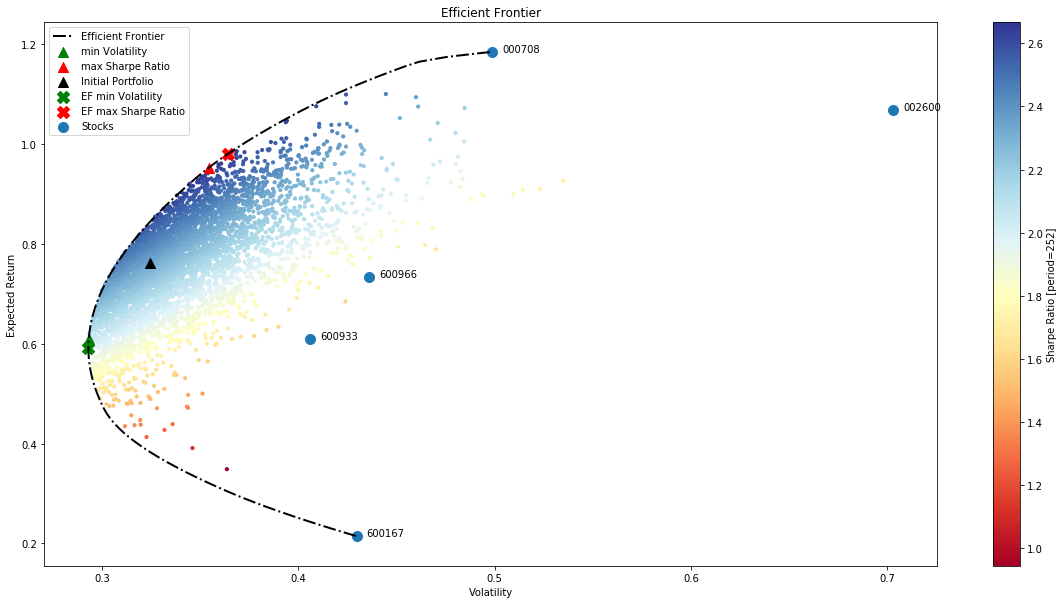

In [28]:
from finquant.monte_carlo import MonteCarloOpt
from finquant.efficient_frontier import  EfficientFrontier


opt_w,opt_res = plot_stock_simulation(df_returns,1)

In [24]:
opt_w

,002367,002683,603859,002582,002324,600305,300055
Min Volatility,0.082005,0.022552,0.003578,0.117189,0.347073,0.153205,0.274397
Max Sharpe Ratio,0.078463,0.296090,0.093380,0.065182,0.431251,0.020320,0.015314


In [25]:
opt_res

,Expected Return,Volatility,Sharpe Ratio
Min Volatility,0.466928,0.270521,1.707550
Max Sharpe Ratio,0.941282,0.325689,2.874777


# HS300

In [26]:
def cal_daily_return(df1):
    df1 = df1[["dt","close"]].drop_duplicates()
    df_test = df1["close"]
    dates = df1.dt.values
    df_test.index = dates
    df_test.index.name = 'Date'
    # calculate daily returns
    daily_returns = df_test.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
    return daily_returns

In [33]:
import pandas as pd
import numpy as np
def hs_300_data(start_date,end_date,freq = 252,risk_free_rate=0.005):
    df1 = pd.read_csv("/home/davidyu/stock/data/test/portfolio/hs_300.csv")
    df2 = df1[(df1["date"]>=start_date)&(df1["date"]<=end_date)]
    df2["dt"] = df2["date"]
    df3 = cal_daily_return(df2)
    df_hs_300 = df3[df3.index.isin(same_date)]
    # daily_returns = df_p.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
    df_returns = df_hs_300
#     print(df_returns.head(10))
    comp_mean_returns = df_returns.mean()*freq
    comp_stock_volatility = df_returns.std() * np.sqrt(freq)
    return_data = {"hs_300_data": df2,
                   'comp_mean_returns': comp_mean_returns,
                   'comp_stock_volatility':comp_stock_volatility,
                   "df_returns":df_returns
                  }
    return return_data

In [35]:
a1=hs_300_data(start_date,end_date)
print(a1.get("comp_mean_returns"))
print(a1.get("comp_stock_volatility"))

0.3971162973094703
0.2121423227684354


In [24]:
#https://blog.csdn.net/weixin_41579863/article/details/106420535
import pandas as pd
import numpy as np
df1 = pd.read_csv("/home/davidyu/stock/data/test/portfolio/hs_300.csv")


df2 = df1[(df1["date"]>=start_date)&(df1["date"]<=end_date)]
df2["dt"]=df2["date"]
def cal_daily_return(df1):
    df1 = df1[["dt","close"]].drop_duplicates()
    df_test = df1["close"]
    dates = df1.dt.values
    df_test.index = dates
    df_test.index.name = 'Date'
    # calculate daily returns
    daily_returns = df_test.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
    return daily_returns
df3=cal_daily_return(df2)

df_hs_300= df3[df3.index.isin(same_date)]


freq = 252
risk_free_rate=0.005
# daily_returns = df_p.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)
df_returns = df_hs_300
print(df_returns.head(10))
comp_mean_returns = df_returns.mean()*freq
comp_stock_volatility = df_returns.std() * np.sqrt(freq)

Date
2020-03-03    0.005331
2020-03-04    0.005790
2020-03-05    0.022277
2020-03-06   -0.016216
2020-03-09   -0.034161
2020-03-10    0.021415
2020-03-11   -0.013301
2020-03-12   -0.019243
2020-03-13   -0.014072
2020-03-16   -0.042993
Name: close, dtype: float64


In [25]:
print(comp_mean_returns)
print(comp_stock_volatility)

0.3971162973094703
0.2121423227684354


In [73]:
df_hs_300 = df_hs_300.reset_index()
df_hs_300.shape

(197, 2)

In [74]:
port_returns = df_returns.apply(lambda x:x.mean(),axis =1).reset_index()
port_returns.columns = ["Date","port_return"]
df_m=pd.merge(df_hs_300,port_returns)
df_m.shape

(197, 3)

In [62]:
df_m['close'].var()

0.000182918531335045

In [76]:
df_m['close'].cov(df_m["port_return"])/df_m['close'].var()


1.1087809171901555

0.00020123716973899982